# Snapshotting for computing the FWI gradient
In forward modeling, ensuring stability requires a sufficiently small time step (`dt`). However, for applying the imaging condition, this restriction can be relaxed, allowing the use of a subsampled time axis. This approach reduces the memory footprint by saving fewer snapshots of the forward wavefield, determined by a `factor`, and applying the imaging condition only at these selected snapshots. Here, we demonstrate snapshotting in Devito, utilizing the `ConditionalDimension` class to compute the FWI gradient efficiently. This notebook follows the `03_fwi.ipynb` notebook in the seismic tutorials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

In [2]:
nshots = 30  # Number of shots to create gradient from
nreceivers = 300  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

# True and smooth velocity models

We will use the Marmousi model. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is a smoothed version of the true model.

In [3]:
# function to get water layer mask
def mask(model,value):
    """
    Return a mask for the model (m) using the (value)
    """
    mask = model > value
    mask = mask.astype(int)
    # mask[:21] = 0
    return mask

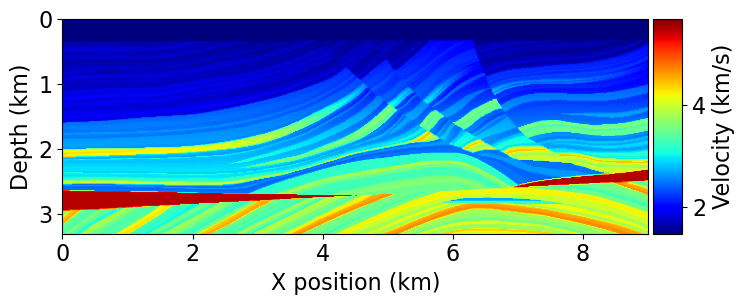

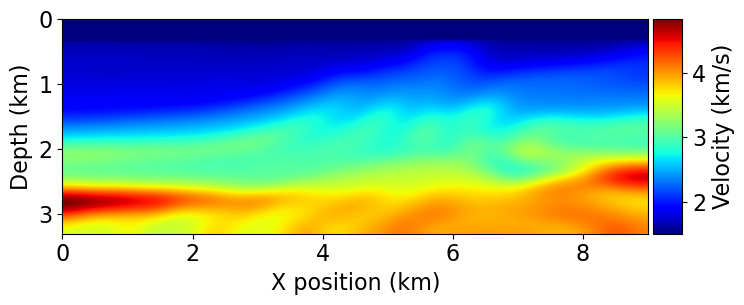

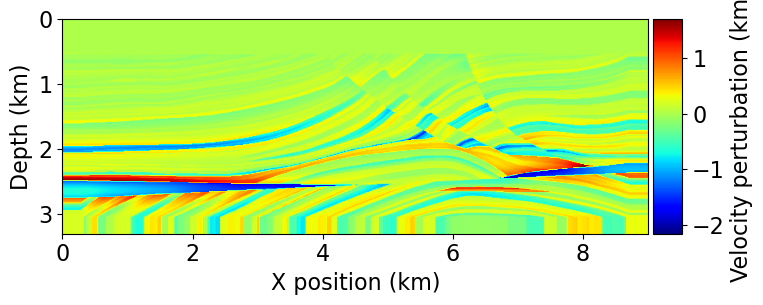

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation, Model
from devito import gaussian_smooth
from scipy.ndimage import gaussian_filter

# Define true and initial model
shape = (601, 221)  # Number of grid point (nx, nz)
spacing = (15., 15.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations
vel_path = '../../../devito/data/Marm.bin'
# Load the true model
model_true = (np.fromfile(vel_path, np.float32).reshape(221, 601))
msk = mask(model_true, 1.5)
model_init = gaussian_filter(model_true, sigma=[10, 15])
model_init = model_init * msk
model_init[model_init==0] = 1.5 # km/s

model = Model(vp=model_true.T, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")
model0 = Model(vp=model_init.T, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp", grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [5]:
assert model.grid == model0.grid
assert model.vp.grid == model0.vp.grid

## Acquisition geometry

In this tutorial, the sources and receiversare are located on the top of the model. This configurations mimic a seismic survey in practice.

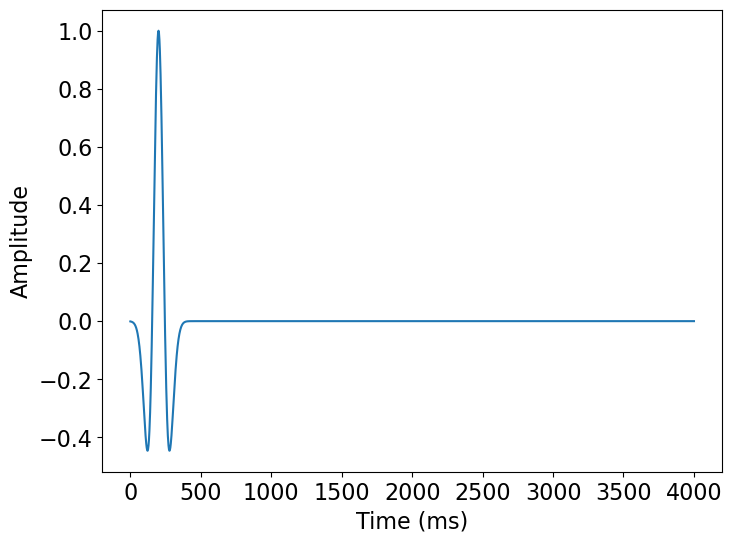

In [6]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 4000. 
f0 = 0.005
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 20.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

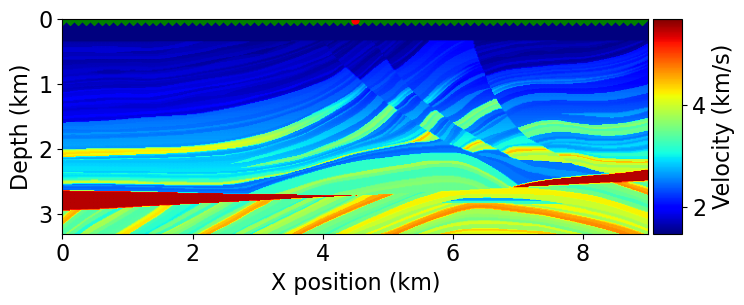

In [7]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [8]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, u0, _ = solver.forward(vp=model.vp)

In [9]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

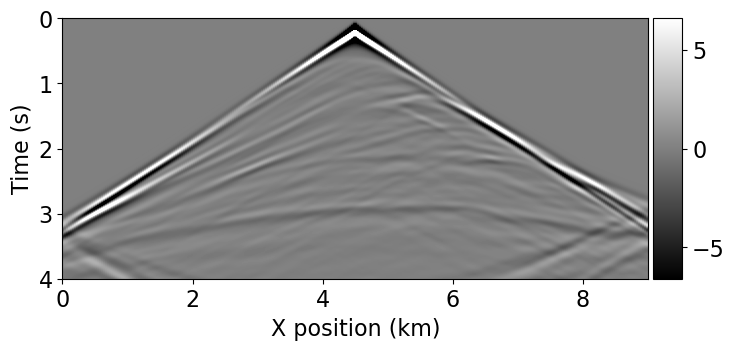

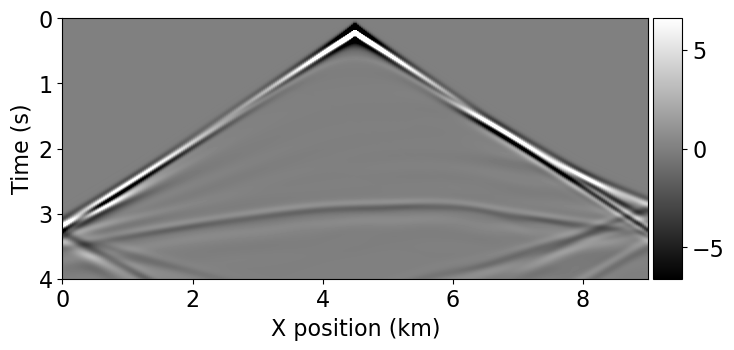

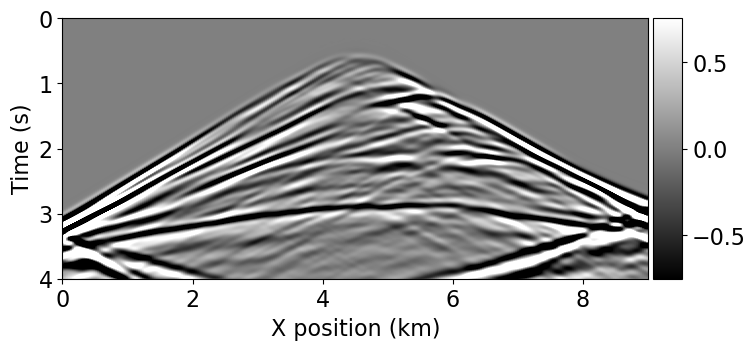

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

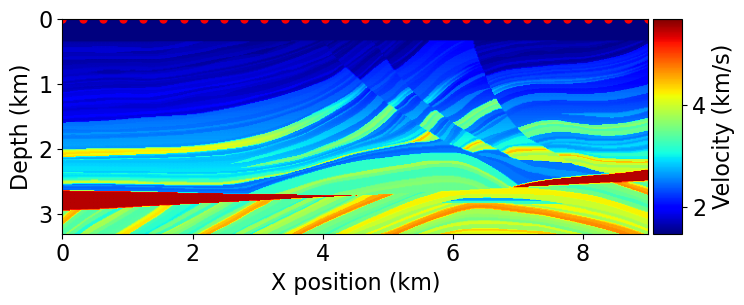

In [11]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.domain_size[0], num=nshots)
source_locations[:, 1] = 0

plot_velocity(model, source=source_locations)

In [12]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [13]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model and visualize it.

In [14]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
print(ff)
print(update.data[:].max())

4199791.287499404
17665.625


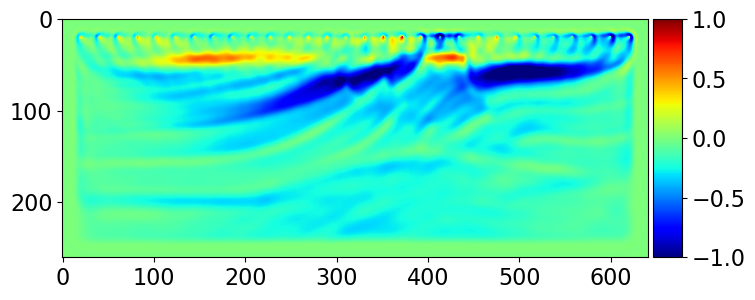

In [15]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(update.data/update.data[:].max(), vmin=-1, vmax=1, cmap="jet")

Now, we compute the gradient using snapshotting with a `factor` of `5`. The only difference is we pass `factor=5` to `solver.forward` and `solver.gradient` to tell Devito to save snapshots of the wavefield every `5dt` time step instead of every `dt` time step. Also, we pass `save=False` to avoid saving the full wavefield as well. The, the imaging condition will be applied only at those snapshots.

In [16]:
model0_snap = Model(vp=model_init.T, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp", grid = model.grid)

In [17]:
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, usnaps, _ = solver.forward(vp=vp_in, save=False, rec=d_syn, factor=5)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=usnaps, vp=vp_in, grad=grad, factor=5)
    
    return objective, grad

In [18]:
ff_snap, update_snap = fwi_gradient(model0_snap.vp)
print(ff_snap)
print(update_snap.data[:].max())
print(ff - ff_snap)

ValueError: Unrecognized argument factor=5

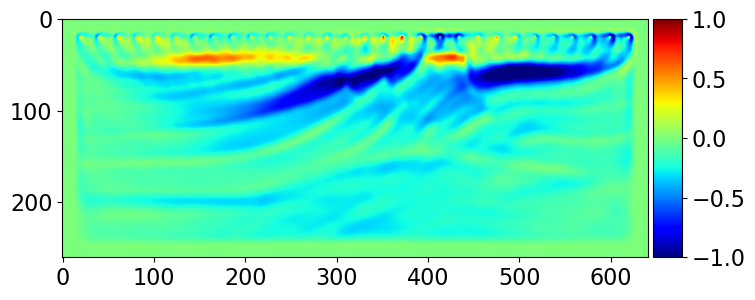

In [ ]:
#NBVAL_IGNORE_OUTPUT

# Plot the FWI gradient
plot_image(update_snap.data/update_snap.data[:].max(), vmin=-1, vmax=1, cmap="jet")

Compare the full gradient with the snapshotted gradient

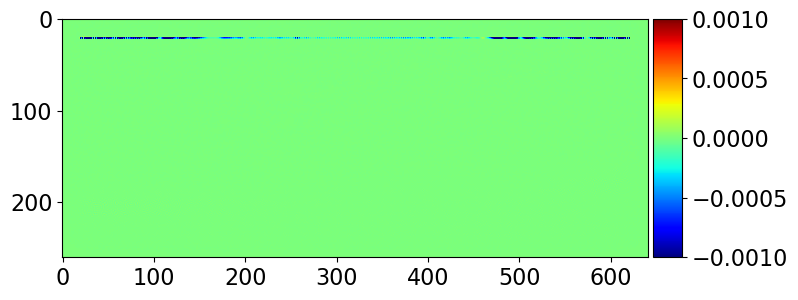

In [ ]:
# Plot the FWI gradient
plot_image((update.data/update.data[:].max()) - (update_snap.data/update_snap.data[:].max()), vmin=-1e-3, vmax=1e-3, cmap="jet")